# Assignment 8

### Teaching Assistants:
- David Tellez: david.tellezmartin@radboudumc.nl
- Wouter Bulten: wouter.bulten@radboudumc.nl

Please submit your notebook via grand-challenge.org (https://ismi-amida13.grand-challenge.org/).
Submit a notebook **WITH ALL CELLS EXECUTED!!!**

* Groups: You should work in pairs or alone
* Deadline for this assignment: 
 * Friday (April 27th) until midnight
 * 5 points (maximum grade = 100 points) penalization per day after deadline
* Submit your **fully executed** notebook to the grand-challenge.org platform

### Your name
Write the name(s) of the author(s) of this assignment below:

# Detection of Mitotic Figures in H&E Stained Breast Cancer Tissue Samples

### The Clinical Problem

Computational Pathology is the branch of Medical Image Analysis that deals with images of Anatomical Pathology, essentially **human cells and tissue structures at very high magnification**. Typically, a piece of human tissue is cut into very thin slices, stained and examined under the microscope by human pathologists. Lately, these slices are digitazed using so-called whole-slide scanners:

<img src="./figures/computational_pathology.png" align="center" width="700">

These digitized slides are called "whole-slide images" (WSIs) and are gigapixel images (typically RGB 100000x100000 pixels):

<img src="./figures/wsi_patches.png" align="center" width="700">

### The Task

Your task is to **build a convolutional neural network that can effectively detect a special structure: mitotic figures**. These are cells that are dividing ([mitosis](https://en.wikipedia.org/wiki/Mitosis)) within a tumor in the breast. Pathologists are interested in detecting and counting these figures because it has been shown that the number of mitotic figures per tissue area is strongly correlated with patient death (survival). In other words, the more mitotic figures per area found in a given tumor sample, the more likely that the patient will die. The hypothesis is that aggressive tumors have more dividing cells than less aggressive ones:

<img src="./figures/mitosis.png" align="center" width="550">

### The Data

To simplify the task, your network will only need to **classify small tissue patches**, instead of entire whole-slide images. We have prepared these patches for you (training and test). Several pathologists have annotated mitotic figures in tissue tiles and we have extracted both positive (mitotic) and negative (non-mitotic) tissue patches from a publicly available dataset. You can see some examples of mitotic figures below (green arrows):

<img src="./figures/amida.png" align="center" width="700">

## This assignment

This assignment consist of 8 subtasks with a total of 100 points:

### Task 1. Data Preprocessing: 10 points
You will explore the data (2.5p), parse filenames (2.5p), create a Pandas dataframe (2.5p), and split the dataset into training and validation (2.5p).

### Task 2. Data Handlers: 15 points
You will create a Keras-compatible mini-batch generator (5p), a Keras-compatible mini-batch sequence (5p), and add support for data augmentation (5p). 

### Task 3. Network Training: 10 points
You will design the network architecture (5p) and train the network with fit_generator (5p).

### Task 4. Training Callbacks: 10 points
You will include Keras callbacks during training (5p), and design a custom plot callback (5p). 

### Task 5. Evaluation: 25 points
You will define the F1-score function (5p), plot the F1-score curve (5p), and create a custom callback to evaluate the validation set at the end of training and find the best detection threshold (10p). Additionally, you will create another custom callback to make predictions on the test set and prepare a submission file (5p).

### Task 6. Train a classifier: 10 points
You will create a function to train a model and submit the results (10p).

### Task 7. Hard negative mining: 10 points
You will obtain scores for the training set (5p), and resample the training set (5p). 

### Task 8. Retrain the classifier: 10 points
You will train the model with the hard dataset and submit the results (10p).

---

As done in previous assignments, in this notebook we provide some parts of code implemented.
Some other parts are not implemented, but we define the variables that will be used in functions, to help you in the development of the assignment.
Things that have been declared but not implemented are assigned a **None** value.
That is the part that you have to implement.
This means that every time you see **None**, it means that something is missing and you have to implement it.

## Reporting your results

When you are done with the assignments you will have to hand in this notebook. Make sure that for each assignment you output a summary of the network architecture and a plot of the loss/accuracy curve during training. This output will be used to grade your assignment.

## Imports

In [1]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob 
import random 
from tqdm import tqdm

# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Deep learning
import keras

# Other
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Download

## If the Jupter server runs on Cartesius

In [5]:
# data_dir = '/projects/0/ismi2018/AMIDA13'

## If the Jupyter server runs on your computer

In [2]:
import requests
from tqdm import tqdm_notebook
import zipfile

link = 'https://surfdrive.surf.nl/files/index.php/s/1acVhUNggKyFLDk/download'
file_name = "ismi-amida13.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./ismi-amida13.zip')
data_dir = './' # define here the directory where you have your data, downloaded from SURFDrive

HBox(children=(IntProgress(value=1, bar_style='info', description='Downloading data', max=1), HTML(value='')))

In [3]:
# Create result dir
result_dir = './results' # define here the directory where your results will be saved
if not exists(result_dir):
    os.mkdir(result_dir)

## Task 1. Data Preprocessing: 10 points
You will explore the data (2.5p), parse filenames (2.5p), create a Pandas dataframe (2.5p), and split the dataset into training and validation (2.5p).

Data preprocessing is typically the task that takes most of the development time when building machine learning applications. In this section, you will learn how to manage your data using the same tools that advanced research labs use. In particular, you will learn the basics of [Pandas](https://pandas.pydata.org/) dataframes.

### Explore the Data (5p)

Investigate the input data: list paths to files, load images, plot them, etc.

Sample positive training path: ./training\positive\0.000655216630548_08_06_Normalized_1635_1047_1.png
Sample negative training path: ./training\negative\0.000100047203887_03_02_Normalized_224_920_0.png
Sample test path: ./test\01_01_Normalized_1001_856.png
There are 319 mitotic and 27325 non-mitotic training patches
There are 13201 test patches


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Some positives examples (shape (101, 101, 3)):


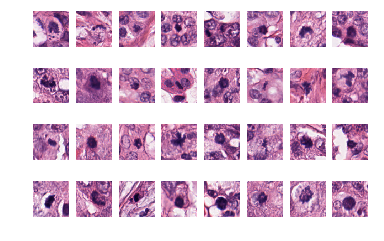

Some negative examples (shape (101, 101, 3)):


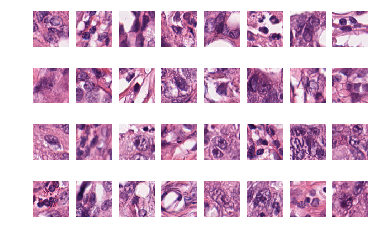

In [4]:
# Collect paths for all images (positive and negative training, and test images)
training_positives_paths = glob(join(data_dir, 'training', 'positive', '*.png'))
training_negatives_paths = glob(join(data_dir, 'training', 'negative', '*.png'))
test_paths = glob(join(data_dir, 'test', '*.png'))

print('Sample positive training path: {path}'.format(path=training_positives_paths[0]))
print('Sample negative training path: {path}'.format(path=training_negatives_paths[0]))
print('Sample test path: {path}'.format(path=test_paths[0]))

print('There are {a} mitotic and {b} non-mitotic training patches'.format(a=len(training_positives_paths), b=len(training_negatives_paths)))
print('There are {a} test patches'.format(a=len(test_paths)))

# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    image = image/255
    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

# Read a few example images and plot them
images_positive = [load_image(path) for path in training_positives_paths[:32]]
images_negative = [load_image(path) for path in training_negatives_paths[:32]]

print('Some positives examples (shape {shape}):'.format(shape=images_positive[0].shape))
plot_image(images_positive, images_per_row=8)

print('Some negative examples (shape {shape}):'.format(shape=images_negative[0].shape))
plot_image(images_negative, images_per_row=8)

### Parsing Filenames (2.5p)

Notice that the file names contain valuable metadata. For example '0.000655216630548_08_06_Normalized_1635_1047_1.png' reflects the following:
* Score (ignore for this assignment): 0.000655216630548
* Patient case: 08
* Tile ID: 06
* Stain standardization status: Normalized
* X-location: 1635
* Y-location: 1047
* Label (mitotic 1, non-mitotic 0): 1

As in many machine learning problems, plenty of metadata is not relevant to the task at hand. For this problem, you will only need the **patient case** and **label**. You will write a function that extracts this information from a given path. Please notice that **test patches do not have score or label**.

In [9]:
# Extract meta-data from a sample patch path in a dictionary format.
def parse_file_name(file_path, test=False):
    
    # Training sample: 0.9620013237_02_27_Normalized_1175_78_1.png
    # Test sample: 01_01_Normalized_1001_856.png
    filename = basename(file_path)
    splitFileName = filename.replace('.png','').split("_")
    
    if not test:
        score = splitFileName[0]
        case = splitFileName[1]
        tile = splitFileName[2]
        _ = splitFileName[3]
        x = splitFileName[4]
        y = splitFileName[5]
        label = splitFileName[6]
    else:
        case = splitFileName[0]
        tile = splitFileName[1]
        _ = splitFileName[2] 
        x = splitFileName[3]
        y = splitFileName[4]
        score = np.nan
        label = -1
    
    data = {
#         'score': float(score),
        'case': int(case),
#         'tile': int(tile),
#         'x': int(x),
#         'y': int(y),
        'label': int(label),
        'file_id': filename
    }
    
    return data

info1 = parse_file_name(training_positives_paths[0], test=False)
print('The following information is available for patch path {path}:'.format(path=training_positives_paths[0]))
print(info1)

info2 = parse_file_name(test_paths[0], test=True)
print('The following information is available for patch path {path}:'.format(path=test_paths[0]))
print(info2)

The following information is available for patch path ./training\positive\0.000655216630548_08_06_Normalized_1635_1047_1.png:
{'label': 1, 'case': 8, 'file_id': '0.000655216630548_08_06_Normalized_1635_1047_1.png'}
The following information is available for patch path ./test\01_01_Normalized_1001_856.png:
{'label': -1, 'case': 1, 'file_id': '01_01_Normalized_1001_856.png'}


### Create a Pandas Dataframe (2.5p)

Our data consists of two main folders, training and test, that contain thousands of RGB 101x101 pixel image patches. We need to divide the training set into actual training and validation sets, so that we can control overfitting during training. We will manage these sets with Pandas' dataframe structures. A dataframe is basically a table where each row is a sample and each column is an attribute (label, case, filename, etc.). Pandas provides extremely convenient functions to work with this kind of data. You can convert a list of dictionaries to a dataframe very easily. Tutorials on pandas can be found here https://pandas.pydata.org/pandas-docs/stable/tutorials.html

The code below gives a small overview of basic functions of a Pandas' data frame.

In [10]:
# Example
data_dict = [
    {'a': 1, 'b': 1, 'c': 2},
    {'a': 0, 'b': 4, 'c': 1},    
    {'a': 0, 'b': 4}
]

print('My dataframe looks like:')
df = pd.DataFrame(data_dict)
print(df)

print('Columns or rows can be selected with loc[] and iloc[]:')
print('Col "b":')
col = df.loc[:, 'b']  # ":" means "select all items"
print(col)
print('Row 1:')
row = df.iloc[1, :]
print(row)

print('Conditional selection can be also done with loc[]:')
print('Show columns "a" and "b" of elements where column "b" is 4:')
sel = df.loc[df['b']==4, ['a', 'b']]
print(sel)

My dataframe looks like:
   a  b    c
0  1  1  2.0
1  0  4  1.0
2  0  4  NaN
Columns or rows can be selected with loc[] and iloc[]:
Col "b":
0    1
1    4
2    4
Name: b, dtype: int64
Row 1:
a    0.0
b    4.0
c    1.0
Name: 1, dtype: float64
Conditional selection can be also done with loc[]:
Show columns "a" and "b" of elements where column "b" is 4:
   a  b
1  0  4
2  0  4


In [11]:
# Get lists of image paths (we use "all" to refer to training+validation data)
all_paths = glob(join(data_dir, 'training', '*', '*.png'))
test_paths = glob(join(data_dir, 'test', '*.png'))

# Parse file names into dictionaries
all_data_dicts = [parse_file_name(path) for path in all_paths]
test_data_dicts = [parse_file_name(path, True) for path in test_paths]

# Convert list of dictionaries to Pandas dataframe
df_all_data = pd.DataFrame(all_data_dicts)
df_test_data = pd.DataFrame(test_data_dicts)


# Explore dataframe
print('There are {a} mitotic and {b} non-mitotic training patches'.format(
    a=len(df_all_data.loc[df_all_data['label']==1, :]), 
    b=len(df_all_data.loc[df_all_data['label']==0, :])
))
print('There are {a} test patches'.format(a=len(df_test_data)))
df_all_data

There are 319 mitotic and 27325 non-mitotic training patches
There are 13201 test patches


,case,file_id,label
0,3,0.000100047203887_03_02_Normalized_224_920_0.png,0
1,2,0.000100151344668_02_28_Normalized_293_563_0.png,0
2,12,0.000100162658782_12_06_Normalized_1549_1082_0...,0
3,7,0.000100229612144_07_33_Normalized_704_1891_0.png,0
4,8,0.000100249366369_08_01_Normalized_422_1219_0.png,0
5,7,0.000100292309071_07_22_Normalized_828_901_0.png,0
6,4,0.000100311663118_04_49_Normalized_276_697_0.png,0
7,2,0.000100341509096_02_08_Normalized_1331_341_0.png,0
8,4,0.000100366843981_04_61_Normalized_1382_1937_0...,0
9,2,0.000100410245068_02_17_Normalized_646_720_0.png,0


### Split Data into Training, Validation and Test (2.5p)

We will use Pandas functionality to divide the dataset into training, validation and test according to patient case, and store the resulting dataframes into disk. Typically, dataframes are stored in CSV format. Use patient cases [4, 5, 7, 8, 12] cases for training and [2, 3, 9] for validation.

In [12]:
# Set patient case
training_cases = [8, 4, 12, 5, 7] 
validation_cases = [9, 3, 2] 

# Shuffle all data
df_all_data = df_all_data.sample(len(df_all_data), replace=False).reset_index(drop=True)

# Select rows whose 'case' column is among the training list
idx_rows_within_training = df_all_data['case'].isin(training_cases)
# Create a dataframe that consists of only the training cases (Hint: can be done with a single line using Pandas)
df_training_data = df_all_data.loc[idx_rows_within_training]
#df_training_data = pd.DataFrame(df_all_data, index = training_cases)

# Select rows whose 'case' column is among the validation list
idxs_rows_within_validation = df_all_data['case'].isin(validation_cases)
# Create a dataframe that consists of only the validation cases (Hint: can be done with a single line using Pandas)
df_validation_data = df_all_data.loc[idxs_rows_within_validation]
#df_validation_data = pd.DataFrame(df_all_data, validation_cases)

# Store file names into disk
df_training_data.to_csv(join(result_dir, 'training_data.csv'))
df_validation_data.to_csv(join(result_dir, 'validation_data.csv'))
df_test_data.to_csv(join(result_dir, 'test_data.csv'))

# Load CSV data from disk (to check that saving works)
df_training_data = pd.DataFrame.from_csv(join(result_dir, 'training_data.csv'), header=0, index_col=0)
df_validation_data = pd.DataFrame.from_csv(join(result_dir, 'validation_data.csv'), header=0, index_col=0)
df_test_data = pd.DataFrame.from_csv(join(result_dir, 'test_data.csv'), header=0, index_col=0)

# Verify that training dataframe contains training cases only (same for validation and test dataframes)
unique_cases_in_training = df_training_data['case'].unique()
print('Cases present in the training dataframe: {cases}'.format(cases=unique_cases_in_training))
unique_cases_in_validation = df_validation_data['case'].unique()
print('Cases present in the validation dataframe: {cases}'.format(cases=unique_cases_in_validation))
unique_cases_in_test = df_test_data['case'].unique()
print('Cases present in the test dataframe: {cases}'.format(cases=unique_cases_in_test))

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


Cases present in the training dataframe: [ 4  7 12  5  8]
Cases present in the validation dataframe: [2 3 9]
Cases present in the test dataframe: [ 1  6 10 11]


## Task 2. Data Handlers: 15 points 

In this task you will get familiar with Keras [generators](https://keras.io/models/model/#fit_generator). This are structures that will help you manage data during training, encapsulating certain data functionality and isolating it from the rest of the code. 

### Data Generator (5p)

A generator will provide us with ready-to-use training batches. In Python, a [generator](https://wiki.python.org/moin/Generators) is an iterable object that implements the next() method. **Given a data directory and CSV path**, this object will encapsulate all the complexity of managing training data: reading patches from disk, augmentation, batch ensembling, formatting, etc. We will later use this object with Keras to feed CNNs during training. Our generator must return a new random batch on every call to `next()`.

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


PatchGenerator detected: 19157 patch samples.


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(32, 101, 101, 3)
(32, 2)


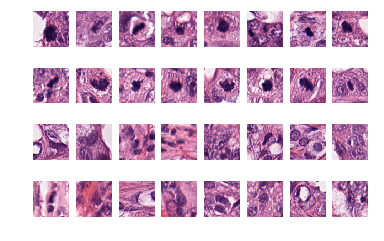

In [13]:
class PatchGenerator(object):
    
    def __init__(self, input_dir, csv_path, batch_size, augmentation_fn=None):
        
        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.csv_path = csv_path  # path to CSV with data split
        self.batch_size = batch_size  # number of patches per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Info
        self.n_samples = len(self.df)
        self.n_batches = self.n_samples // self.batch_size
        
        # Print some info
        print('PatchGenerator detected: {n_samples} patch samples.'.format(n_samples=self.n_samples))

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch
        
        # Randomly sample positive samples from the dataframe 
        # Tip: self.df.loc[self.df['label'] == 1, :].sample(...)
        df_positives = self.df.loc[self.df['label'] == 1, :].sample(round(self.batch_size/2))
        
        # Randomly sample negative samples from the dataframe
        df_negatives =  self.df.loc[self.df['label'] == 0, :].sample(round(self.batch_size/2))
        
        # Concatenate positive and negative sample dataframes
        df_batch = pd.concat([df_positives, df_negatives])

        # Iterate over selected images 
        images = []
        labels = []
        for index, row in df_batch.iterrows():
            
            try:

                # Read image path
                image_path = glob(join(self.input_dir, row['file_id']))
                assert len(image_path) == 1
                image_path = image_path[0]

                # Read data and label
                image = load_image(image_path)
                label = row['label']

                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                images.append(image)
                labels.append((1-label, label))
                
            except Exception as e:
                print('Failed reading idx {idx}...'.format(idx=index))

        # Assemble batch            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, batch_y
    
# Test the data generator
training_gen = PatchGenerator(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'), 
    batch_size=32
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

### Data Sequence (5p)

A Keras Sequence is very similar to a generator but designed for validation data. The main difference is that **sequences read the data in a deterministic way: always the same data in the same order** (vs. generators that read the patches randomly). Other minor differences: there is no augmentation and mini-batches are not balanced. 

A sequence is like a list, accessed via indexes. This means that Keras training will iterate over the length of the sequence (that you provide). Since the number of patches might not be evenly divisible by the number of samples per batch, the last mini-batch might be smaller that batch size.

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


PatchSequence detected: 8487 patch samples.


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(32, 101, 101, 3)
(32, 2)


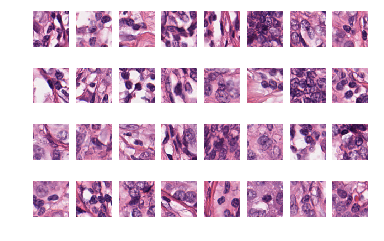

In [14]:
class PatchSequence(keras.utils.Sequence):

    def __init__(self, input_dir, csv_path, batch_size):

        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.csv_path = csv_path  # path to CSV with data split
        self.batch_size = batch_size  # number of patches per batch
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Length
        self.n_samples = len(self.df)
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('PatchSequence detected: {n_samples} patch samples.'.format(n_samples=len(self.df)))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def get_all_labels(self):
        return self.df.loc[:, 'label'].values
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        labels = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                # Read image path
                row = self.df.iloc[i, :]
                image_path = glob(join(self.input_dir, row['file_id']))
                assert len(image_path) == 1
                image_path = image_path[0]

                # Read data and label
                image = load_image(image_path)
                label = row['label']
 

                # Append
                images.append(image)
                labels.append((1-label, label))
                
            except Exception as e:
                print('Failed reading idx {idx}...'.format(idx=i))

        # Assemble batch            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, batch_y

# Test the sequence
validation_seq = PatchSequence(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'validation_data.csv'), 
    batch_size=32
)

for batch_x, batch_y in validation_seq:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

### Data Augmentation (5p)

Add support for basic data augmentation (vertical and horizontal mirroring, and 90-degree rotation). 

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


PatchGenerator detected: 19157 patch samples.


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


(32, 101, 101, 3)
(32, 2)


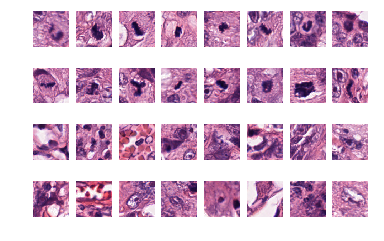

In [15]:
def basic_augmentation(image_array):
    
    # Vertical mirroring
    if np.random.rand() > 0.5:
        image_array = np.flipud(image_array)

    # Horizontal mirroring
    if np.random.rand() > 0.5:
        image_array = np.fliplr(image_array)

    # 90-degree rotation
    if np.random.rand() > 0.5:
        image_array = np.rot90(image_array)
    
    return image_array

# Test basic augmentation
training_gen = PatchGenerator(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'), 
    batch_size=32,
    augmentation_fn=basic_augmentation
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    break

## Task 3. Network Training: 10 points

In this task, you will define the network architecture and get familiar with fit_generator().

### Network Architecture (5p)

Define a model for binary classification compatible with the data and labels provided before. 

In [16]:
def build_model():

    tensor_input = keras.Input(shape=(101,101,3))
    flattened = keras.layers.Flatten()(tensor_input)
    
    tensor = keras.layers.Dense(32, kernel_initializer='normal', activation='relu')(flattened)


    #tensor = keras.layers.Dense(1024, kernel_initializer='normal', activation='relu')(flattened)
#     tensor = keras.layers.Dense(512, kernel_initializer='normal', activation='relu')(tensor)
#     tensor = keras.layers.Dense(256, kernel_initializer='normal', activation='relu')(tensor)
# #     tensor = keras.layers.Dropout(0.4)(tensor)
#     tensor = keras.layers.Dense(128, kernel_initializer='normal', activation='relu')(tensor)
    tensor = keras.layers.Dense(2, kernel_initializer='uniform', activation='relu')(tensor)

    model = keras.models.Model(inputs=tensor_input, outputs=tensor)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 101, 101, 3)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30603)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                979328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 979,394
Trainable params: 979,394
Non-trainable params: 0
_________________________________________________________________


### Training (5p)

You will use Keras fit_generator function to train the model using the data generators that we defined earlier.

In [17]:
# Training data
training_data = PatchGenerator(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'), 
    batch_size=32
)

# Validation data
validation_data = PatchSequence(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'validation_data.csv'), 
    batch_size=32
)

# Train model
history = model.fit_generator(training_data, steps_per_epoch=598, epochs=5, validation_data=validation_data )

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


PatchGenerator detected: 19157 patch samples.


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


PatchSequence detected: 8487 patch samples.
Epoch 1/5


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


233/598 [==========>...................] - ETA: 18:15 - loss: nan - acc: 0.593 - ETA: 9:26 - loss: nan - acc: 0.546 - ETA: 4:52 - loss: nan - acc: 0.52 - ETA: 3:20 - loss: nan - acc: 0.51 - ETA: 2:33 - loss: nan - acc: 0.51 - ETA: 2:05 - loss: nan - acc: 0.50 - ETA: 1:47 - loss: nan - acc: 0.50 - ETA: 1:34 - loss: nan - acc: 0.50 - ETA: 1:30 - loss: nan - acc: 0.50 - ETA: 1:27 - loss: nan - acc: 0.50 - ETA: 1:24 - loss: nan - acc: 0.50 - ETA: 1:21 - loss: nan - acc: 0.50 - ETA: 1:19 - loss: nan - acc: 0.50 - ETA: 1:17 - loss: nan - acc: 0.50 - ETA: 1:15 - loss: nan - acc: 0.50 - ETA: 1:13 - loss: nan - acc: 0.50 - ETA: 1:12 - loss: nan - acc: 0.50 - ETA: 1:10 - loss: nan - acc: 0.50 - ETA: 1:09 - loss: nan - acc: 0.50 - ETA: 1:08 - loss: nan - acc: 0.50 - ETA: 1:06 - loss: nan - acc: 0.50 - ETA: 1:05 - loss: nan - acc: 0.50 - ETA: 1:04 - loss: nan - acc: 0.50 - ETA: 1:03 - loss: nan - acc: 0.50 - ETA: 1:02 - loss: nan - acc: 0.50 - ETA: 1:02 - loss: nan - acc: 0.50 - ETA: 1:01 - loss: 

460/598 [======================>.......] - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan 

598/598 [==============================] - ETA: 10s - loss: nan - acc: 0.500 - ETA: 9s - loss: nan - acc: 0.500 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ET

232/598 [==========>...................] - ETA: 14s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 19s - loss: nan - acc: 0.500 - ETA: 21s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 29s - loss: nan - acc: 0.500 - ETA: 30s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan 

460/598 [======================>.......] - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan 

598/598 [==============================] - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 

233/598 [==========>...................] - ETA: 20s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 20s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 29s - loss: nan - acc: 0.500 - ETA: 30s - loss: nan - acc: 0.500 - ETA: 30s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 34s - loss: nan 

460/598 [======================>.......] - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan 

598/598 [==============================] - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 

233/598 [==========>...................] - ETA: 16s - loss: nan - acc: 0.500 - ETA: 16s - loss: nan - acc: 0.500 - ETA: 16s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 17s - loss: nan - acc: 0.500 - ETA: 20s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 30s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 34s - loss: nan - acc: 0.500 - ETA: 34s - loss: nan - acc: 0.500 - ETA: 34s - loss: nan - acc: 0.500 - ETA: 35s - loss: nan - acc: 0.500 - ETA: 35s - loss: nan - acc: 0.500 - ETA: 35s - loss: nan - acc: 0.500 - ETA: 36s - loss: nan - acc: 0.500 - ETA: 36s - loss: nan - acc: 0.500 - ETA: 36s - loss: nan - acc: 0.500 - ETA: 36s - loss: nan 

460/598 [======================>.......] - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 25s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan 

598/598 [==============================] - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 

233/598 [==========>...................] - ETA: 14s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 15s - loss: nan - acc: 0.500 - ETA: 16s - loss: nan - acc: 0.500 - ETA: 19s - loss: nan - acc: 0.500 - ETA: 21s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 29s - loss: nan - acc: 0.500 - ETA: 29s - loss: nan - acc: 0.500 - ETA: 30s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 31s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 32s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan - acc: 0.500 - ETA: 33s - loss: nan 

460/598 [======================>.......] - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 24s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 23s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan - acc: 0.500 - ETA: 22s - loss: nan 

598/598 [==============================] - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 8s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 7s - loss: nan - acc: 0.50 - ETA: 

## Task 4. Training Callbacks: 10 points

Keras offers an excellent mechanism to extend the functionality of fit_generator: [callback functions](https://keras.io/callbacks/). These callbacks allow you to save model checkpoints, reduce the learning rate during training, and other things. They are call at given events during training (beginning, end, after epoch, etc.). 

### Basic callbacks (5p)

Explore the [callback functions](https://keras.io/callbacks/) and find out how to: a) reduce the learning rate when the validation loss plateaus, b) stop training if validation loss does not improve after 5 epochs, and c) save the best model weights according to the validation loss.

In [18]:
# Define simple callbacks
network_path = join(result_dir, 'best_model.h5')
callbacks_list = [
    keras.callbacks.ModelCheckpoint(network_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
]

# Train model
history = model.fit_generator(training_data, steps_per_epoch=599, epochs=5, callbacks=callbacks_list, validation_data=validation_data)


Epoch 1/5

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


227/599 [==========>...................] - ETA: 58s - loss: nan - acc: 0.500 - ETA: 1:02 - loss: nan - acc: 0.50 - ETA: 59s - loss: nan - acc: 0.5000 - ETA: 59s - loss: nan - acc: 0.500 - ETA: 59s - loss: nan - acc: 0.500 - ETA: 58s - loss: nan - acc: 0.500 - ETA: 58s - loss: nan - acc: 0.500 - ETA: 58s - loss: nan - acc: 0.500 - ETA: 57s - loss: nan - acc: 0.500 - ETA: 58s - loss: nan - acc: 0.500 - ETA: 1:00 - loss: nan - acc: 0.50 - ETA: 59s - loss: nan - acc: 0.5000 - ETA: 58s - loss: nan - acc: 0.500 - ETA: 56s - loss: nan - acc: 0.500 - ETA: 55s - loss: nan - acc: 0.500 - ETA: 54s - loss: nan - acc: 0.500 - ETA: 53s - loss: nan - acc: 0.500 - ETA: 52s - loss: nan - acc: 0.500 - ETA: 52s - loss: nan - acc: 0.500 - ETA: 51s - loss: nan - acc: 0.500 - ETA: 50s - loss: nan - acc: 0.500 - ETA: 50s - loss: nan - acc: 0.500 - ETA: 49s - loss: nan - acc: 0.500 - ETA: 49s - loss: nan - acc: 0.500 - ETA: 49s - loss: nan - acc: 0.500 - ETA: 48s - loss: nan - acc: 0.500 - ETA: 48s - loss: na

454/599 [=====================>........] - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 28s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 27s - loss: nan - acc: 0.500 - ETA: 26s - loss: nan 

599/599 [==============================] - ETA: 11s - loss: nan - acc: 0.500 - ETA: 11s - loss: nan - acc: 0.500 - ETA: 11s - loss: nan - acc: 0.500 - ETA: 11s - loss: nan - acc: 0.500 - ETA: 11s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 10s - loss: nan - acc: 0.500 - ETA: 9s - loss: nan - acc: 0.500 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ETA: 9s - loss: nan - acc: 0.50 - ET

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\keras\callbacks.py:529: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\keras\callbacks.py:939: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.epsilon)


### Custom Callback (5p)

Callbacks can be customized. In this task, you are required to design one that generates a plot of the loss and validation loss during training after each epoch.

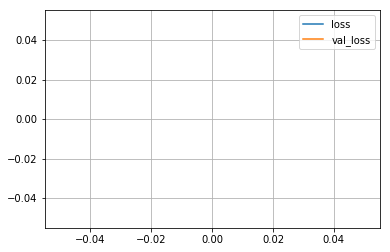

In [22]:
class PlotLosses(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.grid()
        plt.legend()
        plt.show();

# Append to list of callbacks
callbacks_list = [PlotLosses()]

# Train model
history = model.fit_generator(training_data, steps_per_epoch=599, epochs=5, callbacks=callbacks_list, validation_data=validation_data)


## Task 5. Evaluation: 25 points

You will define the F1-score function (5p), plot the F1-score curve (5p), and create a custom callback to evaluate the validation set at the end of training and find the best detection threshold (10p). Additionally, you will create another custom callback to make predictions on the test set and prepare a submission file (5p).

### F1-score (5p)

We will use the [F1-score metric](https://en.wikipedia.org/wiki/F1_score) to measure performance. This metric is common in detection problems with unbalanced class problems.

In [23]:
# Definition of F1-score
# Tip: use precision_recall_curve() to help you compute precision and recall.

def f1_score(y_true, y_pred):
    
    # Compute precision, recall and obtain several detection thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    thresholds = np.append(thresholds, thresholds[-1])
    
    # Compute F1-score and remove numerical problems
    f1 =  2 * (precision * recall) / (precision + recall)
    thresholds = thresholds[~np.isnan(f1)]
    f1 = f1[~np.isnan(f1)]
    
    return f1, thresholds

### F1-score curve (5p)

Create a function that plots the F1-score with respect to the detection threshold.

In [24]:
def plot_f1_curve(y_true, y_pred, output_path):
    
    # Compute F1-score
    f1, thresholds = f1_score(y_true, y_pred)
    
    # Plot
    tag = 'Max %f @ %f' % (np.max(f1), thresholds[np.argmax(f1)])
    plt.plot(thresholds, f1, label=tag)
    plt.title('F1-score')
    plt.ylim(0.0, 1)
    plt.xlim(0.0, 1)
    plt.grid(b=True, which='both')
    plt.legend(loc='upper left')
    plt.savefig(output_path)
    plt.close()

### Evaluation of Validation Set (10p)

After training the model, you will have to select the optimal detection threshold that maximizes the F1-score. You will do this automatically by creating a custom callback that does the following steps at the end of the training:
* Load the best model from disk
* Load the validation set as a Sequence
* Run the model over the validation samples
* Get labels from validation set
* Compute the F1-score
* Saves the F1-score curve plot to disk
* Saves the best detection threshold to disk

In [26]:
class FindBestDetectionThreshold(keras.callbacks.Callback):

    def __init__(self, data_dir, csv_dir, result_dir):
        self.data_dir = data_dir
        self.csv_dir = csv_dir
        self.result_dir = result_dir
        super(FindBestDetectionThreshold, self).__init__()

    def on_train_end(self, epoch, logs=None):
        
        print('Evaluating validation set ...')
        
        # Load best model
        model_path = join(self.result_dir, 'best_model.h5')
        best_model = keras.models.load_model(model_path)
        
        # Load validation set as a sequence
        validation_seq = PatchSequence(
            input_dir=join(self.data_dir, 'training', '*'), 
            csv_path=join(self.csv_dir, 'validation_data.csv'), 
            batch_size=32
        )
        
        # Run the model over samples
        y_pred = self.model.predict_generator(validation_seq)[:, 1]
        
        # Get labels
        y_true = validation_seq.get_all_labels()
        
        # Compute F1-score
        f1, thresholds = f1_score(y_true, y_pred)
        
        # Save F1-score curve
        plot_f1_curve(y_true, y_pred, join(self.result_dir, 'f1-score_validation.png'))

        # Save best detection threshold
        th = {'threshold': thresholds[np.argmax(f1)], 'f1': f1[np.argmax(f1)]}
        pd.DataFrame(th, index=[0]).to_csv(join(self.result_dir, 'best_threshold.csv'))

### Evaluation of Test Set (5p)

After training the model, you will have to make predictions for every sample in the test set and create a CSV file for the submission to https://ismi-amida13.grand-challenge.org/

We will take advantage of Keras callbacks to generate the CSV automatically at the end of the training. You will create a callback that does the following at the end of the training:
* Load the best model from disk
* Load the test set as a Sequence
* Run the model over the test samples
* Read best threshold file
* Threshold predictions
* Store the predictions in a suitable CSV for the submission

In [27]:
class CreateFinalSubmission(keras.callbacks.Callback):

    def __init__(self, data_dir, csv_dir, result_dir):
        self.data_dir = data_dir
        self.csv_dir = csv_dir
        self.result_dir = result_dir
        super(CreateFinalSubmission, self).__init__()

    def on_train_end(self, epoch, logs=None):
        
        print('Evaluating test set ...')

        # Load best model
        model_path = join(self.result_dir, 'best_model.h5')
        best_model = keras.models.load_model(model_path)
        
        # Load test set as a sequence
        test_seq = PatchSequence(
            input_dir=join(self.data_dir, 'test'), 
            csv_path=join(self.csv_dir, 'test_data.csv'), 
            batch_size=32
        )
        
        # Run the model over samples
        y_pred = self.model.predict_generator(test_seq)[:, 1]
        
        # Read best threshold
        df_th = pd.DataFrame.from_csv(join(self.result_dir, 'best_threshold.csv'))
        th = df_th.threshold
        print(th)
        
        # Threshold predictions TODO hier moet nog iets. Even koppen bij elkaar?
        y_pred_bin = None

        # Make CSV
        df = test_seq.df
        df['label'] = y_pred_bin
        df['file_id'] = df['file_id'].apply(lambda x: x[:-4])
        df = df.loc[:, ['label', 'file_id']]
        df.to_csv(join(self.result_dir, 'submission.csv'), index=None)

## Task 6. Train a classifier: 10 points

You will create a function to train a model and submit the results (10p). The function should follow the next steps:
* Define the training generator with augmentation
* Define the validation sequence
* Build the model
* Define simple and advanced callbacks (in particular: evaluation of validation and test sets)
* Train the model using fit_generator

In [30]:
def train_model(data_dir, csv_dir, result_dir, training_csv, validation_csv, batch_size=32, epochs=10, augmentation_fn=None, debug=False):
    
    # Prepare dir
    if not exists(result_dir):
        os.mkdir(result_dir)
    
    # Training data
    training_data = PatchGenerator(
        input_dir=join(data_dir, 'training', '*'), 
        csv_path=join(csv_dir, training_csv), 
        batch_size=batch_size,
        augmentation_fn=augmentation_fn
    )

    # Validation data
    validation_data = PatchSequence(
        input_dir=join(data_dir, 'training', '*'), 
        csv_path=join(csv_dir, validation_csv), 
        batch_size=batch_size
    )
        
    # Build model
    model = build_model()
    model.summary
    
    # Define callbacks
    callbacks_list = [
        None,
        PlotLosses(),
        FindBestDetectionThreshold(data_dir=data_dir, csv_dir=csv_dir, result_dir=result_dir),
        CreateFinalSubmission(data_dir=data_dir, csv_dir=csv_dir, result_dir=result_dir)
    ]

    # Train model
    history = model.fit_generator(training_data, steps_per_epoch=598, epochs=epochs, verbose=1, callbacks=callbacks_list, validation_data=validation_data)
    
# Train the first model
train_model(
    data_dir=data_dir, 
    csv_dir=result_dir,
    result_dir=join(result_dir, 'initial'),
    training_csv='training_data.csv',
    validation_csv='validation_data.csv', 
    batch_size=32, 
    epochs=1, 
    augmentation_fn=basic_augmentation, 
    debug=True
)

# Remember to submit the results (manually)

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


PatchGenerator detected: 19157 patch samples.


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


PatchSequence detected: 8487 patch samples.
Epoch 1/1


C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


231/598 [==========>...................] - ETA: 2:10:47 - loss: nan - acc: 0.500 - ETA: 43:40 - loss: nan - acc: 0.5000  - ETA: 26:14 - loss: nan - acc: 0.500 - ETA: 18:45 - loss: nan - acc: 0.500 - ETA: 14:36 - loss: nan - acc: 0.500 - ETA: 11:57 - loss: nan - acc: 0.500 - ETA: 11:13 - loss: nan - acc: 0.500 - ETA: 10:42 - loss: nan - acc: 0.500 - ETA: 10:10 - loss: nan - acc: 0.500 - ETA: 9:44 - loss: nan - acc: 0.500 - ETA: 9:19 - loss: nan - acc: 0.50 - ETA: 8:59 - loss: nan - acc: 0.50 - ETA: 8:37 - loss: nan - acc: 0.50 - ETA: 8:20 - loss: nan - acc: 0.50 - ETA: 8:07 - loss: nan - acc: 0.50 - ETA: 7:53 - loss: nan - acc: 0.50 - ETA: 7:39 - loss: nan - acc: 0.50 - ETA: 7:26 - loss: nan - acc: 0.50 - ETA: 7:14 - loss: nan - acc: 0.50 - ETA: 7:04 - loss: nan - acc: 0.50 - ETA: 6:54 - loss: nan - acc: 0.50 - ETA: 6:45 - loss: nan - acc: 0.50 - ETA: 6:37 - loss: nan - acc: 0.50 - ETA: 6:28 - loss: nan - acc: 0.50 - ETA: 6:24 - loss: nan - acc: 0.50 - ETA: 6:22 - loss: nan - acc: 0.50 

458/598 [=====================>........] - ETA: 2:13 - loss: nan - acc: 0.50 - ETA: 2:13 - loss: nan - acc: 0.50 - ETA: 2:12 - loss: nan - acc: 0.50 - ETA: 2:12 - loss: nan - acc: 0.50 - ETA: 2:12 - loss: nan - acc: 0.50 - ETA: 2:11 - loss: nan - acc: 0.50 - ETA: 2:11 - loss: nan - acc: 0.50 - ETA: 2:10 - loss: nan - acc: 0.50 - ETA: 2:10 - loss: nan - acc: 0.50 - ETA: 2:09 - loss: nan - acc: 0.50 - ETA: 2:09 - loss: nan - acc: 0.50 - ETA: 2:09 - loss: nan - acc: 0.50 - ETA: 2:08 - loss: nan - acc: 0.50 - ETA: 2:08 - loss: nan - acc: 0.50 - ETA: 2:07 - loss: nan - acc: 0.50 - ETA: 2:07 - loss: nan - acc: 0.50 - ETA: 2:06 - loss: nan - acc: 0.50 - ETA: 2:06 - loss: nan - acc: 0.50 - ETA: 2:05 - loss: nan - acc: 0.50 - ETA: 2:05 - loss: nan - acc: 0.50 - ETA: 2:05 - loss: nan - acc: 0.50 - ETA: 2:04 - loss: nan - acc: 0.50 - ETA: 2:04 - loss: nan - acc: 0.50 - ETA: 2:03 - loss: nan - acc: 0.50 - ETA: 2:03 - loss: nan - acc: 0.50 - ETA: 2:02 - loss: nan - acc: 0.50 - ETA: 2:02 - loss: nan

597/598 [============================>.] - ETA: 48s - loss: nan - acc: 0.500 - ETA: 47s - loss: nan - acc: 0.500 - ETA: 47s - loss: nan - acc: 0.500 - ETA: 47s - loss: nan - acc: 0.500 - ETA: 46s - loss: nan - acc: 0.500 - ETA: 46s - loss: nan - acc: 0.500 - ETA: 46s - loss: nan - acc: 0.500 - ETA: 45s - loss: nan - acc: 0.500 - ETA: 45s - loss: nan - acc: 0.500 - ETA: 45s - loss: nan - acc: 0.500 - ETA: 44s - loss: nan - acc: 0.500 - ETA: 44s - loss: nan - acc: 0.500 - ETA: 43s - loss: nan - acc: 0.500 - ETA: 43s - loss: nan - acc: 0.500 - ETA: 43s - loss: nan - acc: 0.500 - ETA: 42s - loss: nan - acc: 0.500 - ETA: 42s - loss: nan - acc: 0.500 - ETA: 42s - loss: nan - acc: 0.500 - ETA: 41s - loss: nan - acc: 0.500 - ETA: 41s - loss: nan - acc: 0.500 - ETA: 41s - loss: nan - acc: 0.500 - ETA: 40s - loss: nan - acc: 0.500 - ETA: 40s - loss: nan - acc: 0.500 - ETA: 39s - loss: nan - acc: 0.500 - ETA: 39s - loss: nan - acc: 0.500 - ETA: 39s - loss: nan - acc: 0.500 - ETA: 38s - loss: nan 

KeyboardInterrupt: 

## Task 7. Hard negative mining: 10 points

By training a CNN to perform a discriminative task, we are effectively **building a decision boundary (an hyper-plane) that is able to separate mitotic from non-mitotic patches**. In particular, each training sample that the classifier sees pushes and changes the shape of this decision boundary so that more and more difficult samples are correctly classified.

If you check the negative samples available in the dataset, you will quickly realize that **most of them are very easy to classify**. Typically, they depict tissue that has nothing to do with mitotic figures, therefore, the classifier quickly learns to discriminate those. However, the algorithm will fail in negative patches that resemble mitotic figures (difficult samples). These samples are scarce, therefore, the CNN is not penalized enough for that. For us, this is important since detecting only a few mitotic figures wrong is troublesome (this is common in medical applications). 

In order to push the performance of our model further, we will include difficult samples more often in the training set. We will define the difficulty of a sample based on the prediction score produced by the initial model. If a training sample is classified with very low probability, then it's an easy sample, otherwise, it's a difficult one.

### Compute scores for test set (5p)

The first thing you will do is computing a prediction score for each training sample and store it in a Pandas dataframe together with the rest of the sample attributes.

In [ ]:
# Read the training set as a sequence
training_seq = PatchSequence(
    input_dir=join(data_dir, 'training', '*'), 
    csv_path=join(result_dir, 'training_data.csv'),
    batch_size=32
)

# Load the initial mode
model_path = join(result_dir, 'initial', 'best_model.h5')
initial_model = None

# Predict
y_train_pred = initial_model.predict_generator(None)

# Store in dataframe
df_training_data = pd.DataFrame.from_csv(join(result_dir, 'training_data.csv'))
df_training_data['pred'] = None
df_training_data

### Resample the training set (5p)

You will create a new training dataset (CSV file) based on the prediction scores. Sample the same number of samples, with replacement, proportionally to these scores so that difficult negative samples are sampled more often. Make sure you keep the same positive samples.

In [ ]:
# Select all positive samples
df_training_positives = None

# Select all negative samples
df_training_negatives = None

# Resample negative samples proportionally to their scores
df_training_hard_negatives = df_training_negatives.sample(None)

# Concatenate positives and hard negative samples
df_hard_training_data = pd.concat([df_training_positives, df_training_hard_negatives])

# Store CSV on disk
df_hard_training_data.to_csv(join(result_dir, 'difficult_training_data.csv'))

Plot histograms of scores before and after sampling and make sure there are more difficult samples in the second set.

In [ ]:
df_training_data.loc[df_training_data['label'] == 0, :].hist('pred')
plt.show()
df_hard_training_data.loc[df_hard_training_data['label'] == 0, :].hist('pred')
plt.show()

## Task 8. Retrain the Classifier: 10 points

You will train the model with the hard dataset and submit the results (10p). 

In [ ]:
# Train the second model
train_model(None)

# Remember to submit the results (manually)